In [7]:
import time
import math
import os
import torch.nn as nn

import torch.onnx
import torch
from torch.autograd import Variable
import torch.optim as optim

import model as rnn_model
import data

In [2]:
args_seed = 1234
args_temperature = 1.
args_data = '../data/wikitext-2'
args_model = 'LSTM'
args_emsize = 200
args_nhid = 200
args_nlayers = 2
args_lr = 20
args_clip = 0.25
args_epochs = 40
args_batch_size = 20
args_bptt = 35
args_dropout = 0.2
args_log_interval = 200
args_save = 'model.pt'
args_tied = True

In [3]:
torch.manual_seed(args_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'using device: {device}')

using device: cpu


In [4]:
###############################################################################
# Load data
###############################################################################

corpus = data.Corpus(args_data)

In [5]:
# Starting from sequential data, batchify arranges the dataset into columns.
# For instance, with the alphabet as the sequence and batch size 4, we'd get
# ┌ a g m s ┐
# │ b h n t │
# │ c i o u │
# │ d j p v │
# │ e k q w │
# └ f l r x ┘.
# These columns are treated as independent by the model, which means that the
# dependence of e. g. 'g' on 'f' can not be learned, but allows more efficient
# batch processing.

def batchify(data, bsz):
    # Work out how cleanly we can divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

eval_batch_size = 10
train_data = batchify(corpus.train, args_batch_size)
val_data = batchify(corpus.valid, eval_batch_size)
test_data = batchify(corpus.test, eval_batch_size)

In [6]:
###############################################################################
# Build the model
###############################################################################

ntokens = len(corpus.dictionary)
model = rnn_model.RNNModel(args_model, ntokens, args_emsize, args_nhid, args_nlayers, args_dropout, args_tied).to(device)

criterion = nn.CrossEntropyLoss()

In [8]:
###############################################################################
# Use Adam optimizer
###############################################################################

# create your optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [10]:
###############################################################################
# Training code
###############################################################################

def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

In [13]:
# get_batch subdivides the source data into chunks of length args.bptt.
# If source is equal to the example output of the batchify function, with
# a bptt-limit of 2, we'd get the following two Variables for i = 0:
# ┌ a g m s ┐ ┌ b h n t ┐
# └ b h n t ┘ └ c i o u ┘
# Note that despite the name of the function, the subdivison of data is not
# done along the batch dimension (i.e. dimension 1), since that was handled
# by the batchify function. The chunks are along dimension 0, corresponding
# to the seq_len dimension in the LSTM.

def get_batch(source, i):
    seq_len = min(args_bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target


def evaluate(data_source):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    total_loss = 0.
    ntokens = len(corpus.dictionary)
    hidden = model.init_hidden(eval_batch_size)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, args_bptt):
            data, targets = get_batch(data_source, i)
            output, hidden = model(data, hidden)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
            hidden = repackage_hidden(hidden)
    return total_loss / len(data_source)


def train():
    # Turn on training mode which enables dropout.
    model.train()
    total_loss = 0.
    start_time = time.time()
    ntokens = len(corpus.dictionary)
    hidden = model.init_hidden(args_batch_size)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, args_bptt)):
        data, targets = get_batch(train_data, i)
        # Starting each batch, we detach the hidden state from how it was previously produced.
        # If we didn't, the model would try backpropagating all the way to start of the dataset.
#         hidden = repackage_hidden(hidden)
#         model.zero_grad()
#         output, hidden = model(data, hidden)
#         loss = criterion(output.view(-1, ntokens), targets)
#         loss.backward()
        
        #####
        # in your training loop:
        hidden = repackage_hidden(hidden)
        optimizer.zero_grad()   # zero the gradient buffers
        output, hidden = model(data, hidden)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        optimizer.step()    # Does the update
        ####
#         # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
#         torch.nn.utils.clip_grad_norm(model.parameters(), args_clip)
#         for p in model.parameters():
#             p.data.add_(-lr, p.grad.data)

        total_loss += loss.item()

        if batch % args_log_interval == 0 and batch > 0:
            cur_loss = total_loss / args_log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | lr {:02.2f} | ms/batch {:5.2f} | '
                    'loss {:5.2f} | ppl {:8.2f}'.format(
                epoch, batch, len(train_data) // args_bptt, lr,
                elapsed * 1000 / args_log_interval, cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()


In [ ]:
# Loop over epochs.
lr = args_lr
best_val_loss = None

# At any point you can hit Ctrl + C to break out of training early.
try:
    for epoch in range(1, args_epochs+1):
        epoch_start_time = time.time()
        train()
        val_loss = evaluate(val_data)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
                'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                           val_loss, math.exp(val_loss)))
        print('-' * 89)
        # Save the model if the validation loss is the best we've seen so far.
        if not best_val_loss or val_loss < best_val_loss:
            with open(args_save, 'wb') as f:
                torch.save(model, f)
            best_val_loss = val_loss
        else:
            # Anneal the learning rate if no improvement has been seen in the validation dataset.
            lr /= 4.0
except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')

| epoch   1 |   200/ 2983 batches | lr 20.00 | ms/batch 974.29 | loss  7.75 | ppl  2317.33
| epoch   1 |   400/ 2983 batches | lr 20.00 | ms/batch 903.98 | loss  6.91 | ppl  1006.85


In [31]:
# Load the best saved model.
with open(args_save, 'rb') as f:
    model = torch.load(f)
    # after load the rnn params are not a continuous chunk of memory
    # this makes them a continuous chunk, and will speed up forward pass
    model.rnn.flatten_parameters()

# Run on test data.
test_loss = evaluate(test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)


| End of training | test loss  4.61 | test ppl   100.09


# Try to generate with this model now

In [5]:
args_data = '../data/wikitext-2'
args_checkpoint = './model.pt'
args_state_dict = './model_state.pt'
args_outf = 'generated.txt'
args_words = 1000
args_seed = 1234
args_temperature = 1.0
args_log_interval = 100

In [6]:
# Set the random seed manually for reproducibility.
torch.manual_seed(args_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [7]:
if args_temperature < 1e-3:
    print("args_temperature has to be greater or equal 1e-3")


TypeError: __init__() missing 5 required positional arguments: 'rnn_type', 'ntoken', 'ninp', 'nhid', and 'nlayers'

RNNModel(
  (drop): Dropout(p=0.2)
  (encoder): Embedding(33278, 200)
  (rnn): LSTM(200, 200, num_layers=2, dropout=0.2)
  (decoder): Linear(in_features=200, out_features=33278, bias=True)
)

In [11]:
corpus = data.Corpus(args_data)
ntokens = len(corpus.dictionary)

In [12]:
# with open(args_checkpoint, 'rb') as f:
#     model = torch.load(f).to(device)
ntokens = len(corpus.dictionary)
model = rnn_model.RNNModel(args_model, ntokens, args_emsize, args_nhid, args_nlayers, args_dropout, args_tied).to(device)


In [13]:
hidden = model.init_hidden(1)
input = torch.randint(ntokens, (1, 1), dtype=torch.long).to(device)

In [14]:
model.eval()

RNNModel(
  (drop): Dropout(p=0.2)
  (encoder): Embedding(33278, 200)
  (rnn): LSTM(200, 200, num_layers=2, dropout=0.2)
  (decoder): Linear(in_features=200, out_features=33278, bias=True)
)

In [15]:
with open(args_outf, 'w') as outf:
    with torch.no_grad():  # no tracking history
        for i in range(args_words):
            output, hidden = model(input, hidden)
            word_weights = output.squeeze().div(args_temperature).exp().cpu()
            word_idx = torch.multinomial(word_weights, 1)[0]
            input.fill_(word_idx)
            word = corpus.dictionary.idx2word[word_idx]

            outf.write(word + ('\n' if i % 20 == 19 else ' '))

            if i % args_log_interval == 0:
                print('| Generated {}/{} words'.format(i, args_words))

| Generated 0/1000 words
| Generated 200/1000 words
| Generated 400/1000 words
| Generated 600/1000 words
| Generated 800/1000 words


In [15]:
model.state_dict()

torch.Size([33278, 200])

In [10]:
## Save State Dictionary
with open('model_state.pt', 'wb') as f:
    torch.save(model.state_dict(), f)


## What do the embeddings look like?

In [78]:
import scipy
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [18]:
model.state_dict().keys()

odict_keys(['encoder.weight', 'rnn.weight_ih_l0', 'rnn.weight_hh_l0', 'rnn.bias_ih_l0', 'rnn.bias_hh_l0', 'rnn.weight_ih_l1', 'rnn.weight_hh_l1', 'rnn.bias_ih_l1', 'rnn.bias_hh_l1', 'decoder.weight', 'decoder.bias'])

In [19]:
model.state_dict()['encoder.weight'].shape

torch.Size([33278, 200])

In [21]:
embeds = model.state_dict()['encoder.weight']

In [27]:
embeds_factored = numpy.linalg.svd(embeds, full_matrices=False)

In [29]:
[_.shape for _ in embeds_factored]

[(33278, 200), (200,), (200, 200)]

In [38]:
embeds_left = embeds_factored[0]

In [44]:
embeds_left[:, :2]

array([[-7.9910283e-04, -3.1548047e-03],
       [ 1.0722986e-03,  4.3260949e-03],
       [-2.7345107e-03,  7.4653453e-03],
       ...,
       [ 1.1549407e-03, -6.9848800e-05],
       [-6.5904637e-03, -6.8776676e-04],
       [ 3.1645244e-04, -1.2559209e-02]], dtype=float32)

In [60]:
np.array(list(corpus.dictionary.word2idx.keys()))

array(['<eos>', '=', 'Valkyria', ..., 'Nests', 'flea', 'gallinae'],
      dtype='<U20')

In [94]:
some_words = ['flour', 'water', 'bread', 'coffee', 'driving', 'car', 'horse', 'chicken', 'bird', 'cow', 'leg']
some_words

['flour',
 'water',
 'bread',
 'coffee',
 'driving',
 'car',
 'horse',
 'chicken',
 'bird',
 'cow',
 'leg']

In [95]:
some_idxs = [corpus.dictionary.word2idx[word] for word in some_words]

In [96]:
print(embeds[some_idxs].shape)
np.array(embeds[some_idxs])

torch.Size([11, 200])


array([[-0.00051434,  0.02033632,  0.09984105, ..., -0.08866936,
         0.09270144,  0.00768542],
       [ 0.0928671 , -0.00151284,  0.06038006, ..., -0.03915505,
        -0.03639407, -0.0217066 ],
       [-0.01913583,  0.0672651 , -0.00388076, ...,  0.04973791,
         0.07833976,  0.03803595],
       ...,
       [ 0.02507289, -0.03832237, -0.04943949, ...,  0.04812672,
        -0.06627788, -0.05677483],
       [ 0.0077758 ,  0.02874149,  0.04034439, ...,  0.00379293,
        -0.00689854,  0.02133693],
       [-0.07740116,  0.06057052, -0.09444994, ..., -0.07062232,
        -0.05396214,  0.01295084]], dtype=float32)

In [97]:
tsne = TSNE(n_components=2, random_state=123)
#np.set_printoptions(suppress=True)
Y = tsne.fit_transform(np.array(embeds[some_idxs]))


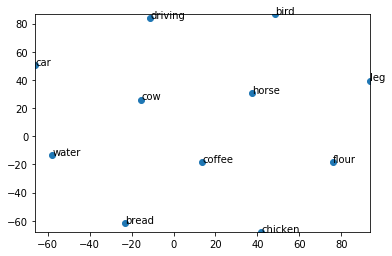

In [98]:
x_coords = Y[:, 0]
y_coords = Y[:, 1]
# display scatter plot
plt.scatter(x_coords, y_coords)

for label, x, y in zip(some_words, x_coords, y_coords):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
plt.show()

Well this is obviously terrible. It must not have found any association. Looking at the generated words, it doesn't make much sense so this isn't terribly surprising. Probably R-200 for embedding space is too small.